In [ ]:
!pip install -r requirements.txt

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import numpy as np
import seaborn as sns

import llm_utils
import opt_utils

In [ ]:
import argparse
parser = argparse.ArgumentParser()
# the following demo is sutiable for gpt2 (all sizes),  OPT, GPT-j and Llama-2-7b 
# we recommend on using gpt2 or OPT, since they have small versions that can be run without GPUs
parser.add_argument('--model_name', type=str, default='gpt2-xl', help='model name (only models from HuggingFace that are supported by llm_utils)')
# parser.add_argument('--model_name', type=str, default='facebook/opt-350m', help='model name (only models from HuggingFace that are supported by llm_utils)')
parser.add_argument('--model_args', type=str, default='')
parser.add_argument('--disable_pad_token', action='store_true')
parser.add_argument('--device', type=str, default=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [ ]:
args, unknown = parser.parse_known_args()
print('unknown args:', unknown)
print('args:', args)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)
if not args.disable_pad_token:
    print(f'adding pad token: {tokenizer.eos_token}')
    tokenizer.pad_token = tokenizer.eos_token

try:
    os.environ["TOKENIZERS_PARALLELISM"] = "true"  # not blocking, just to prevent warnings and faster tokenization
except:
    pass

In [ ]:
device = torch.device(args.device)
print(f'Using device: {device} [cuda available? => {torch.cuda.is_available()}, cuda version: {torch.version.cuda}, args.device = "{args.device}"]')

In [ ]:
model_extra_args = {}
for arg in args.model_args.split(','):
    if arg == '':
        continue
    k, v = arg.split('=')
    model_extra_args[k] = v
print(f'model_extra_args: {model_extra_args}')

model = AutoModelForCausalLM.from_pretrained(args.model_name, **model_extra_args).eval().requires_grad_(False).to(device)
model_aux = llm_utils.model_extra(model=model, device=device)
config = model_aux.config  # should be the same as auto_model_to_config(args.model_name)

n_embd = model_aux.n_embd
n_head = model_aux.n_head
head_size = model_aux.head_size
n_layer = model_aux.n_layer

In [ ]:
model

In [9]:
def get_forward_and_reversed_attn(collector, layer_index, head_index, config, head_size):
    attn_map = collector['attentions'][layer_index][0][head_index].clone().detach().cpu()  # forward pass attn map

    values = collector['kv_cache'][layer_index][1][0][head_index].clone().detach().cpu()

    vjp_output_backpropogated = collector['grad'][layer_index][config.attn_o]['input']
    vjp_output_backpropogated = torch.stack(vjp_output_backpropogated, dim=0)
    vjp_output_backpropogated = vjp_output_backpropogated[:, head_index*head_size:(head_index+1)*head_size].clone().detach().cpu()

    rev_logits = vjp_output_backpropogated @ values.T

    rev_attn = attn_map * (rev_logits.T - torch.diag(attn_map@rev_logits.T)).T / (head_size**0.5)

    return (attn_map, rev_attn)   

In [10]:
prompt = 'I like Italy and France. I visited the city of'
target_new = ' Florence'


prompt_encoded = tokenizer(prompt, return_tensors="pt").to(device)
encoded_line = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
prompt_len = len(prompt_encoded['input_ids'][0])
prompt_list = [tokenizer.decode(x) for x in prompt_encoded['input_ids'][0]]

In [ ]:
model_output = model(encoded_line, output_hidden_states=True, output_attentions=True, use_cache=True)
print(f"[prompt:]{prompt}[answer:]{tokenizer.decode(model_output['logits'][0][-1].argmax(dim=-1))}")

res = opt_utils.get_nll_opt_model(prompt, target_new, model_name=args.model_name, 
            tokenizer=tokenizer, opt='SGD', device=device, lr=1.0,
            model_extra_args=model_extra_args, 
            wrapp_forward_pass_config='AUTO', 
            wrapp_backward_pass_config='AUTO')
sgd_model = res['model']
grad_collector = res['grad_collector']
hs_collector = res['hs_collector']
collector ={
    'grad': grad_collector,
    'hs': hs_collector,
    'kv_cache': model_output['past_key_values'],
    'attentions': model_output['attentions']
}

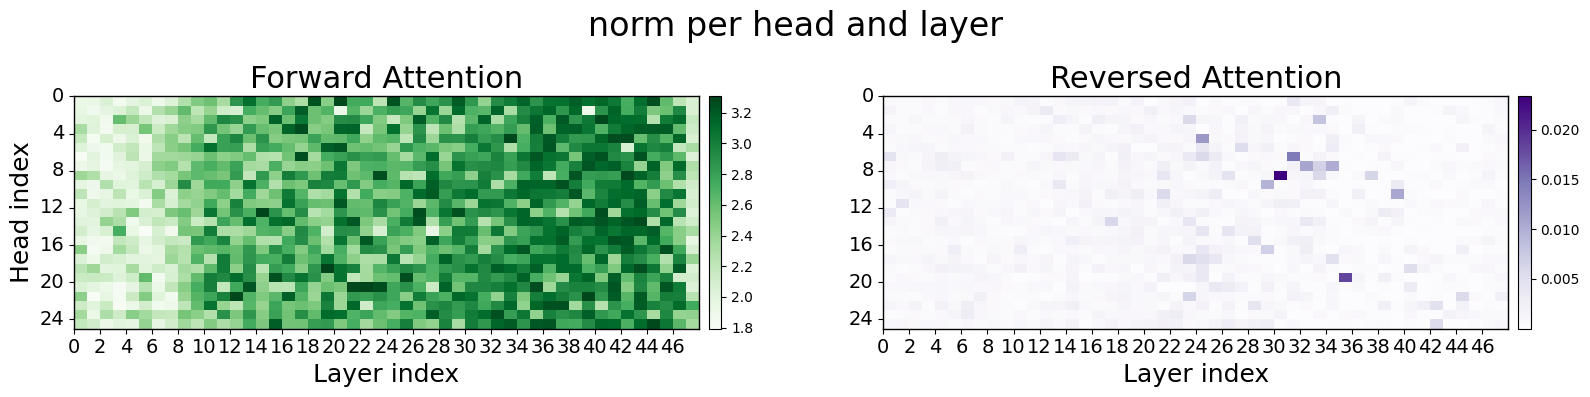

In [12]:
forward_norms = []
reversed_norms = []
reversed_norms_stats = []

for layer_index in range(n_layer):
    forward_row = []
    reversed_row = []
    for head_index in range(n_head):
        forward, reversed = get_forward_and_reversed_attn(collector, layer_index, head_index, config, head_size)
        forward_row.append(forward.norm().item())
        reversed_row.append(reversed.norm().item())
        reversed_norms_stats.append((layer_index, head_index, reversed.norm().item()))
    forward_norms.append(forward_row)
    reversed_norms.append(reversed_row)

forward_norms = np.array(forward_norms).T
reversed_norms = np.array(reversed_norms).T

fig, axes = plt.subplots(1, 2, figsize=(16,4))
annot = False


show_every_n_layer = 1 if n_layer <= 24 else 2
ax = axes.flatten()[0]
sns.heatmap(forward_norms, cmap='Greens', annot=annot, fmt=".2f", annot_kws={"size": 10}, cbar=False, ax=ax)
ax.set_title(f'Forward Attention', fontsize=22)
ax.set_xticks(np.arange(n_layer)[::show_every_n_layer])
ax.set_xticklabels(np.arange(n_layer)[::show_every_n_layer], rotation=0, fontsize=14)
ax.set_yticks(np.arange(n_head, step=4))
ax.set_yticklabels(np.arange(n_head, step=4), rotation=0, fontsize=14)
ax.set_xlabel('Layer index', fontsize=18)
ax.set_ylabel('Head index', fontsize=18)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
plt.colorbar(ax.get_children()[0], cax=cax, orientation='vertical')
for _, spine in ax.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1)

ax = axes.flatten()[1]
sns.heatmap(reversed_norms, cmap='Purples', annot=annot, fmt=".2f", annot_kws={"size": 10}, cbar=False, ax=ax)
ax.set_title(f'Reversed Attention', fontsize=22)
ax.set_xticks(np.arange(n_layer)[::show_every_n_layer])
ax.set_xticklabels(np.arange(n_layer)[::show_every_n_layer], rotation=0, fontsize=14)
ax.set_yticks(np.arange(n_head, step=4))
ax.set_yticklabels(np.arange(n_head, step=4), rotation=0, fontsize=14)
ax.set_xlabel('Layer index', fontsize=18)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
plt.colorbar(ax.get_children()[0], cax=cax, orientation='vertical')
for _, spine in ax.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(1)

plt.suptitle(f'norm per head and layer', fontsize=24)
plt.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.show()

0) layer: 30, head: 8, reversed attention map norm: 0.023333273828029633


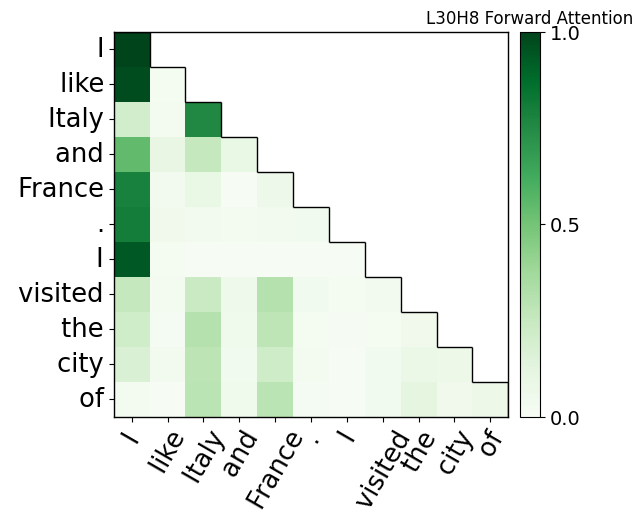

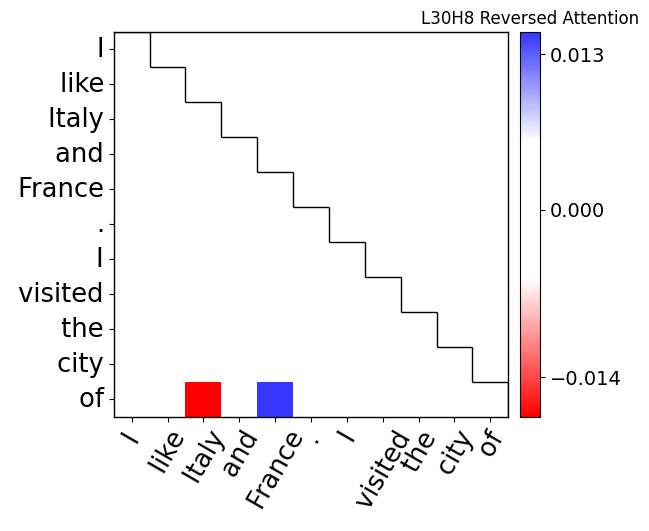

1) layer: 35, head: 19, reversed attention map norm: 0.01838661916553974


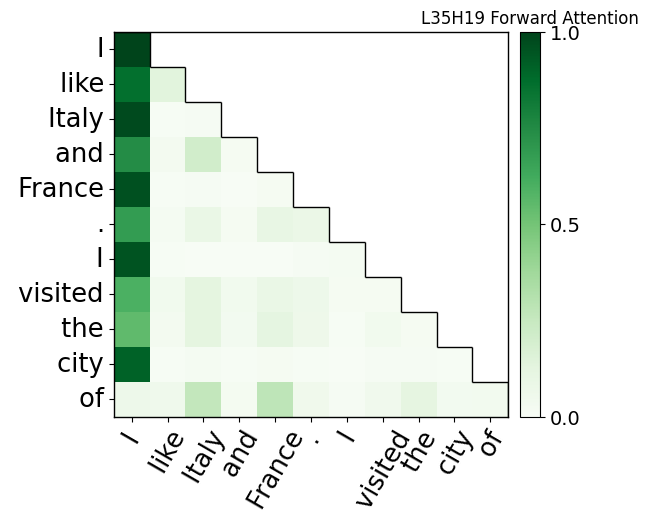

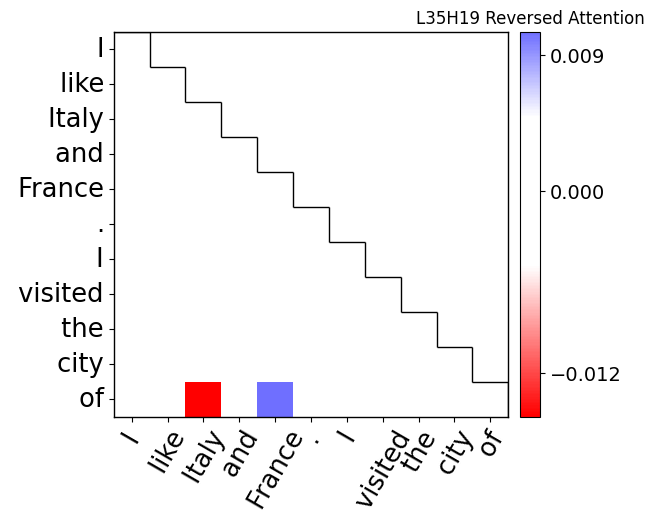

2) layer: 31, head: 6, reversed attention map norm: 0.014736811630427837


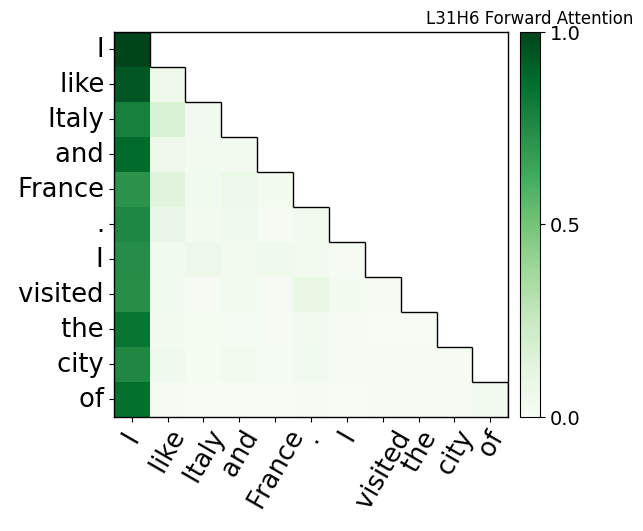

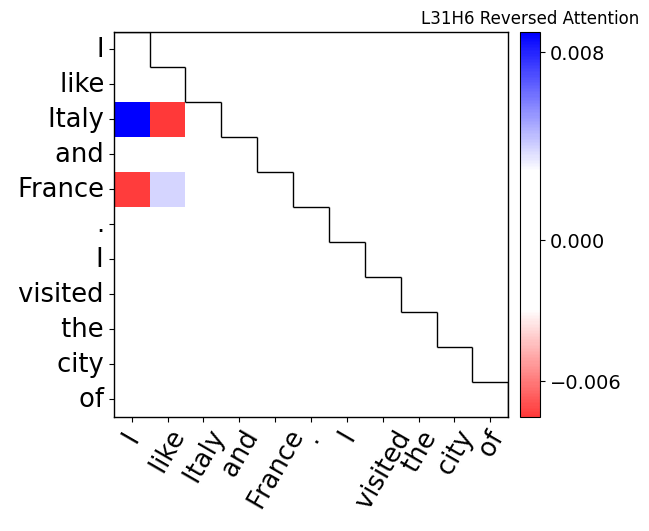

3) layer: 24, head: 4, reversed attention map norm: 0.01192554086446762


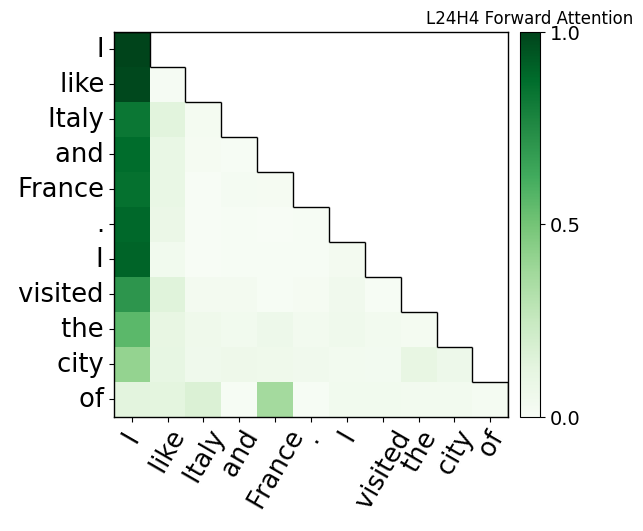

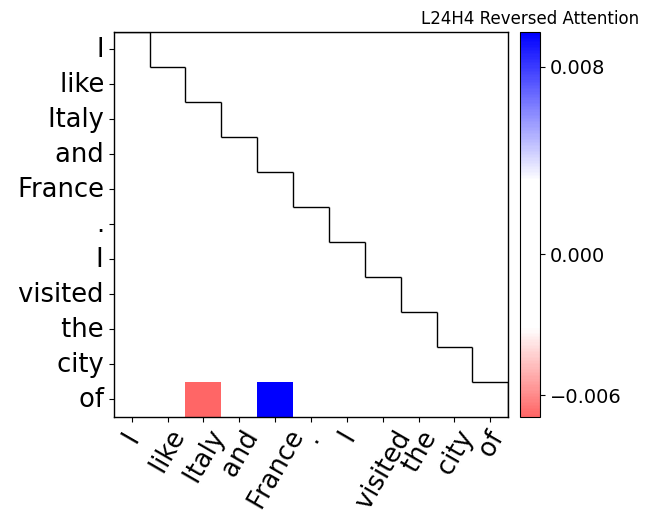

4) layer: 32, head: 7, reversed attention map norm: 0.010773301124572754


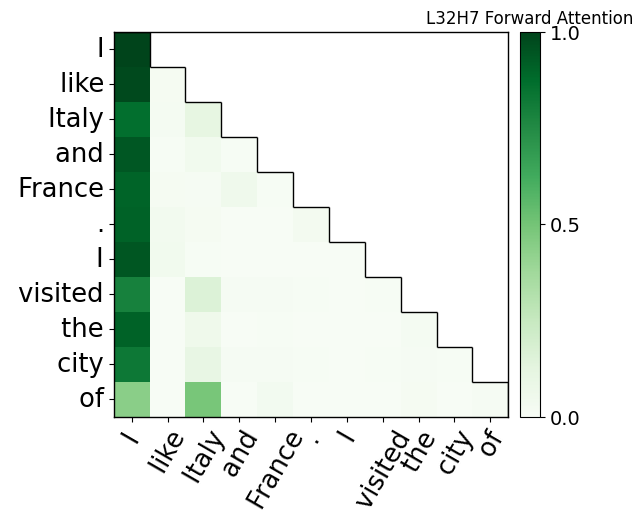

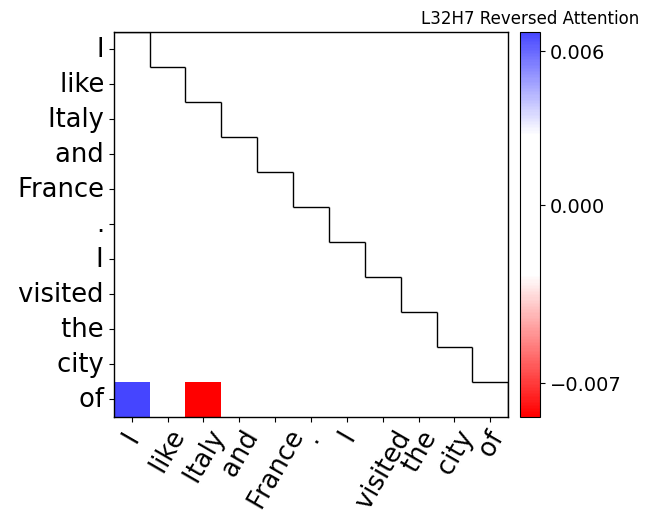

5) layer: 39, head: 10, reversed attention map norm: 0.010612248443067074


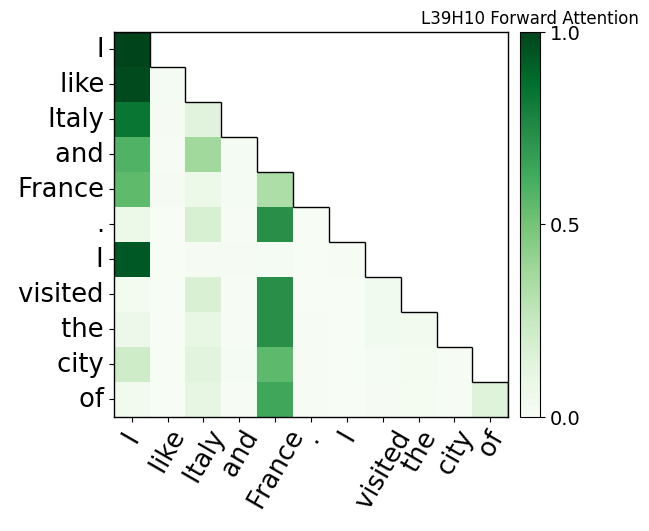

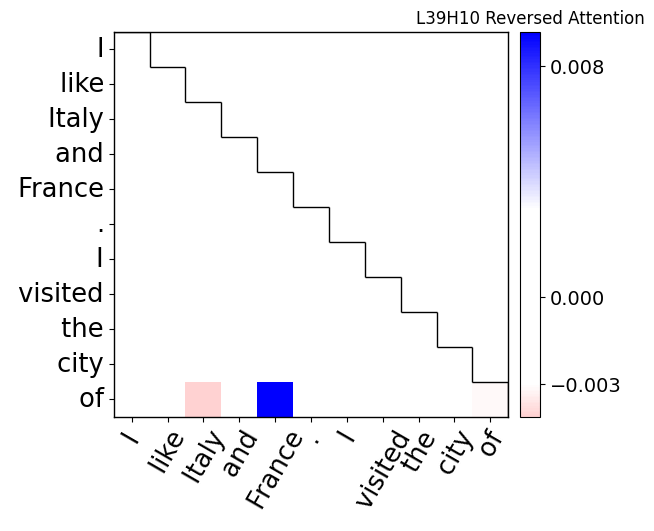

6) layer: 34, head: 7, reversed attention map norm: 0.010200914926826954


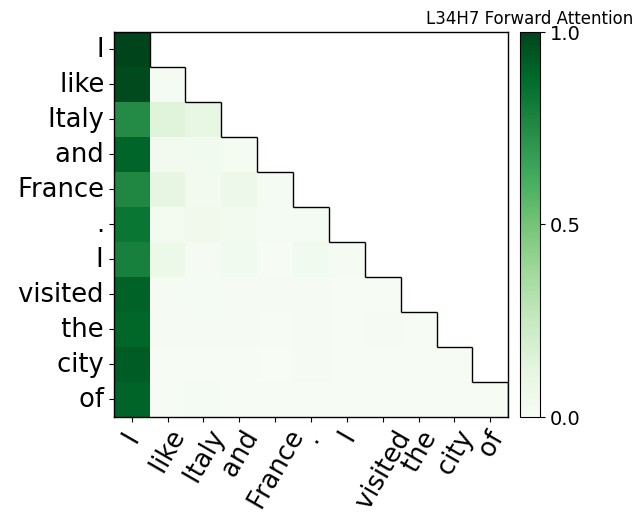

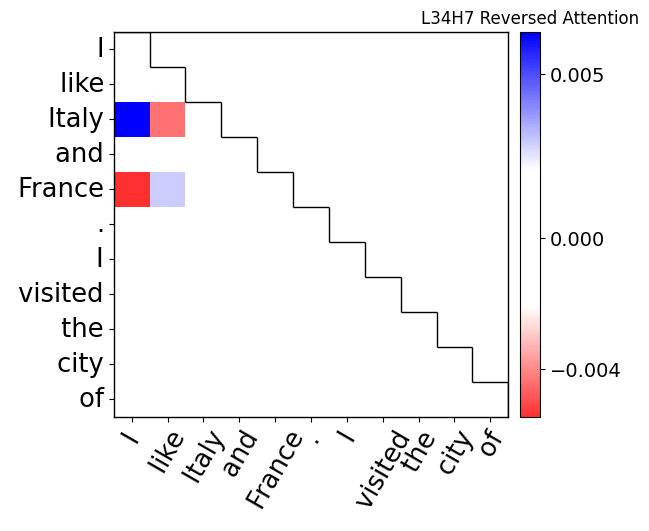

7) layer: 29, head: 9, reversed attention map norm: 0.009582671336829662


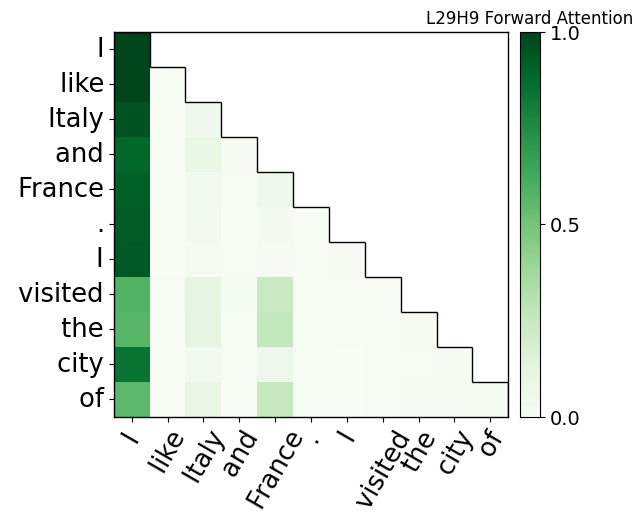

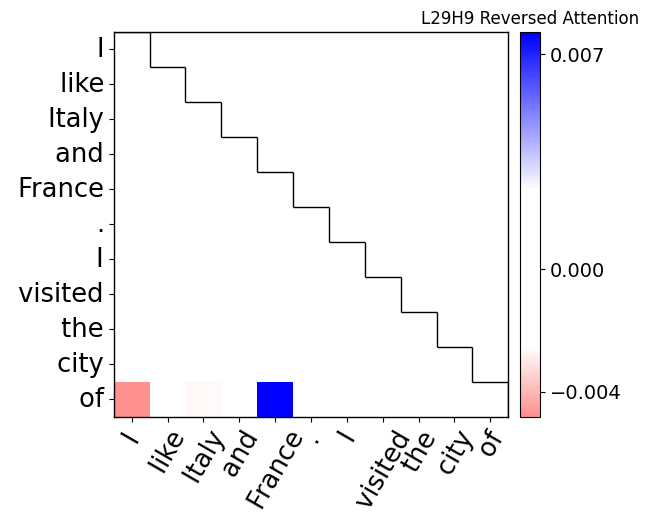

8) layer: 33, head: 2, reversed attention map norm: 0.008032595738768578


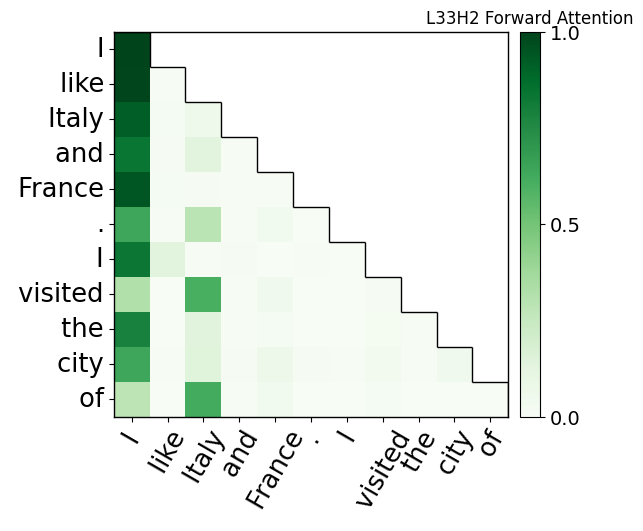

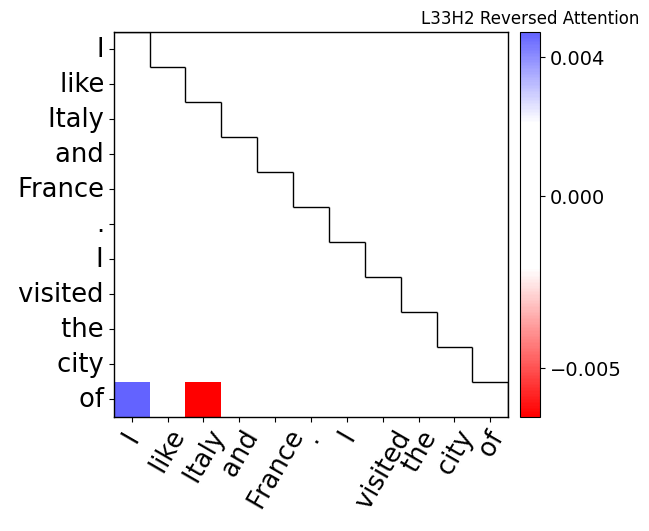

9) layer: 29, head: 16, reversed attention map norm: 0.006764064077287912


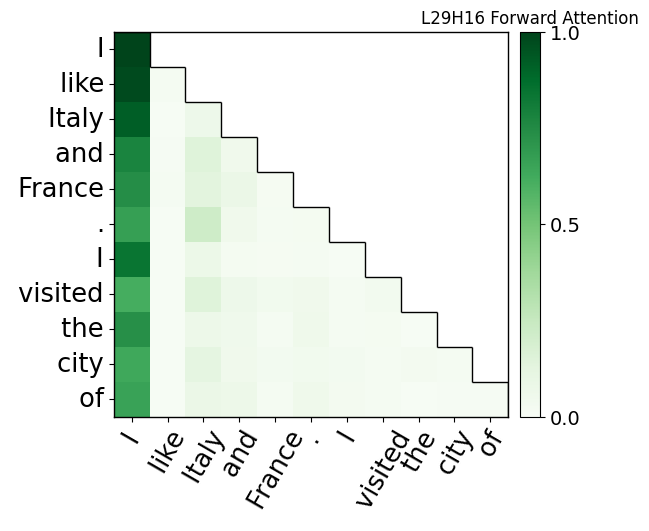

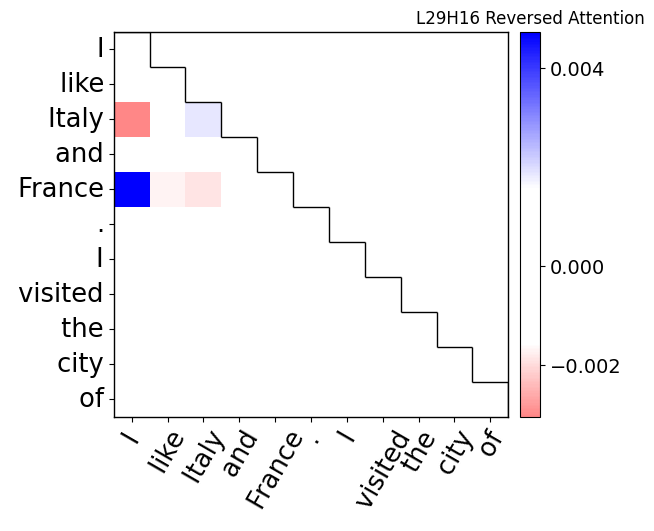

10) layer: 33, head: 7, reversed attention map norm: 0.0066005331464111805


In [13]:
n_attn_heads_to_show = 10

newcmp = LinearSegmentedColormap.from_list("", [ 'red', 'white', 'white', 'blue'])
mask = np.zeros_like(reversed)
mask[np.triu_indices_from(mask, k=1)] = True

prompt_list_tmp = [x.replace('\n', '\\n') for x in prompt_list]
reversed_norms_stats.sort(key=lambda x: x[2], reverse=True)
for i, (layer_index, head_index, value) in enumerate(reversed_norms_stats):
    print(f'{i}) layer: {layer_index}, head: {head_index}, reversed attention map norm: {value}')
    if i >= n_attn_heads_to_show:
        break
    forward, reversed = get_forward_and_reversed_attn(collector, layer_index, head_index, config, head_size)
    annot = False

    plt.figure(figsize=(5.5,5))
    ax = plt.gca()
    sns.heatmap(forward, cmap='Greens', vmin=0, vmax=1, annot=annot, fmt=".4f", mask=mask, annot_kws={"size": 6}, ax=ax, cbar=False)
    ax.set_xticks(np.arange(prompt_len) + 0.5, prompt_list_tmp, rotation=60, fontsize=18.5)
    ax.set_yticks(np.arange(prompt_len) + 0.5, prompt_list_tmp, rotation=0, fontsize=18.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.12)
    cax.tick_params(labelsize=14)
    plt.colorbar(ax.get_children()[0], cax=cax, orientation='vertical')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.5, 1])
    for i in range(forward.shape[0]):
        ax.add_patch(Rectangle((i, i), 1, 0, fill=True, color='black'))
        ax.add_patch(Rectangle((i+1, i), 0, 1, fill=True, color='black'))
    for _, spine in ax.spines.items(): 
        spine.set_visible(True) 
        spine.set_linewidth(1)
    _title = f'L{layer_index}H{head_index} Forward Attention'
    plt.title(_title)
    plt.show()

    plt.figure(figsize=(5.5,5))
    ax = plt.gca()
    sns.heatmap(reversed, cmap=newcmp, center=0, annot=annot, fmt=".4f", mask=mask, annot_kws={"size": 6}, ax=ax, cbar=False)
    ax.set_xticks(np.arange(prompt_len) + 0.5, prompt_list_tmp, rotation=60, fontsize=18.5)
    ax.set_yticks(np.arange(prompt_len) + 0.5, prompt_list_tmp, rotation=0, fontsize=18.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.12)
    cax.tick_params(labelsize=14)
    plt.colorbar(ax.get_children()[0], cax=cax, orientation='vertical')
    cbar = ax.collections[0].colorbar
    max_cbar = round(reversed.max().item() *0.85, 3)
    min_cbar = round(reversed.min().item() *0.80, 3)
    cbar.set_ticks([min_cbar, 0, max_cbar])
    
    for i in range(reversed.shape[0]):
        ax.add_patch(Rectangle((i, i), 1, 0, fill=True, color='black'))
        ax.add_patch(Rectangle((i+1, i), 0, 1, fill=True, color='black'))
    for _, spine in ax.spines.items(): 
        spine.set_visible(True) 
        spine.set_linewidth(1)
    _title = f'L{layer_index}H{head_index} Reversed Attention'
    plt.title(_title)
    plt.show()
    